# Numerical Matrix Methods for the Tilted Potential Well 

Version 0.0.1, 2023 January 19

Hello! This Jupyter notebook will guide you through how matrix methods and the basis states of the infinite potential well can be used to numerically solve the tilted potential well. We will represent our Hamiltonian in the basis of eigenstates of the infinite potential well, then use matrix diagonalization to find our eigenstates and eigenvalues. By truncating our basis to the first $N$ elements, we can obtain an accurate approximate solution to the tilted potential well. For further reading, you are welcome to read the associated paper [here](). For any questions, comments and suggestions, please email rafiullah@lums.edu.pk

This tutorial assumes some basic familiarity with Python and a few commonly used libraries such as NumPy and matplotlib. For some quick references to get acquainted with these, the [Python tutorial](https://docs.python.org/3/tutorial/) and [NumPy quickstart guide](https://numpy.org/doc/stable/user/quickstart.html) are very useful.

In [1]:
#Here we import some standard Python libraries and functions for numerical computing
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg
from scipy.integrate import quad
from scipy.stats import cauchy

#The following line makes sure our matplotlib graphs appear in our notebook
%matplotlib inline 



#The following lines update matplotlib parameters to use LaTeX fonts, allowing us to produce 
#publication quality figures directly in our IPython notebook without additional processing
params = {'text.latex.preamble' : r'\usepackage{lmodern}',
          'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 

#We also define the following function which allows us to print matrices in a readable format
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Setup and parameters

Here, we set the parameters of the system we are using. Here, ${e\_ not}$ is the gradient of the tilt, $a$ is the width of the potential well, $m$ is the mass of the particle, $q$ is the charge of the particle. All parameters here are in Hartree atomic units. A handy list of atomic units with values in SI included can be found [here](https://en.wikipedia.org/wiki/Hartree_atomic_units#Units).

$noOfStates$ is the number of basis states $N$ that will be used to expand the eigenstates of the new Hamiltonian, and changing this to a higher or lower value allows us to control our level of approximation.

In [2]:
e_not = 0.1
a = 10
mass = 1  
q = 1   
hbar = 1

noOfStates = 200

# Setting up our basis
We will represent our Hamiltonian in the basis states $\phi_n(x)$ of the infinite potential well, each with energy $E(n)$. So, we define these as Python functions to aid our future calculations.

In [3]:
#These are energy eigenvalues of the infinite potential well
def E(n): 
    return (n**2)*((np.pi)**2)/(2*mass*(a**2))
#These are the eigenstates of the infinite potential well corresponding to the nth eigenstate
def phi(n,x):
    return np.sqrt(2/a)*np.sin(n*np.pi*x/a)


#Here we just store the eigenvalues of the first N states, for future comparisons
OriginalEnergies = np.zeros(noOfStates)
for i in range(noOfStates):
    OriginalEnergies[i] = E(i+1)

# Setting up the tilted potential well

Since our basis set $\phi_n(x)$ is complete, we can write any Hamiltonian in terms of this basis and completely characterize it by consider all the possible the matrix elements $H_{nm}$ which can be written as
$$ 
H_{nm} = \int_0^a \phi_n(x) \hat{H} \phi_m(x).
$$

This allows us to reframe the tilted well problem as a matrix eigenvalue problem in terms of the basis set of the infinite potential well. The tilted well Hamiltonian can be written (in position space) as 
$$ \hat{H} = -\frac{\hbar^2}{2m}\frac{\partial}{\partial x} + e\mathcal{E}x $$
in the domain $0 < x < a$ and infinite otherwise.

We can then easily use this to calculate the matrix elements, which look like
$$ H_{nm} = \begin{cases}
    E_n + \mathcal{E}\left(\frac{a}{2}\right) & \text{if } m=n,\\
    \frac{-8a\mathcal{E}}{\pi^2}\left(\frac{mn}{(m^2-n^2)^2}\right) & \text{if } m + n \text{ odd},\\
    0 & \text{otherwise.}
  \end{cases}
$$

In this section, we set the tilted well Hamiltonian up by using its representation as these matrix elements and then populating an $N \times N$ matrix with these elements. We will then use this matrix for our eigenvalue and eigenvector calculations. It is important to note that since we are only condsidering a finite dimension for the matrix, we are essentially making an approximation by truncating our basis.

In [4]:
#We write a function to represent the Hamiltonian in terms of its basis elements
def H(n, m):
    if (m == n):
        return E(n) + e_not*(a/2)
    elif ((m+n)%2 == 0):
        return 0
    else:
        return -e_not*(8*a/(np.pi**2))*(m*n/(m**2-n**2)**2)
    
    
#The following code generates a matrix from the above function.
vH = np.vectorize(H) #This step allows us to use NumPy function reserved for vectorized functions
HMatrix = np.fromfunction(vH, (noOfStates+1, noOfStates+1)) #This will generate a matrix using the matrix elements from 0 to N

#However, we typically number our eigenstates for the infinite potential well starting from the 1st eigenstate
#So we disregard the first row and column which contain false references to the "0"th eigenvalue
HMatrix = HMatrix[1:noOfStates+1, 1:noOfStates+1]

# Finding Eigenstates and Eigenvalues
Next we obtain the eigenvalues and eigenvectors of the constructed matrix. The eigenvalues represent the energies of the new system, while the eigenvectors represent the corresponding eigenstates. 

In [5]:
#This function finds the eigenvalues and eigenvectors of a matrix A and then sorts them by their eigenvalue, in an ascending order
def SortedEigen(A):
    #We use the eigh function which can be used for Hermitian matrices
    eigenValues, eigenVectors = linalg.eigh(A)
    
    #We sort the eigenvalues and vectors via the NumPy argsort function
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    return (eigenValues, eigenVectors)

In [6]:
#We use the above defined function to calculate the eigenstates and eigenvalues. This is where the majority of our computation happens
EnergiesH, EigenvectorsH = SortedEigen(HMatrix)

In [7]:
#We define our eigenstates as a linear combination of the states given by phi_n
def psi(n, x):
    val = 0
    for i in range(noOfStates):
        val += EigenvectorsH[i,n-1]*phi(i+1,x)
    return val

# Plotting our new wavefunctions
Now, we will create some simple plots to examine how the presence of the tilt in our well affects our eigenstates. The following code can be used to plot the $n^{th}$ eigenstate, and visually see how are wavefunction changes.

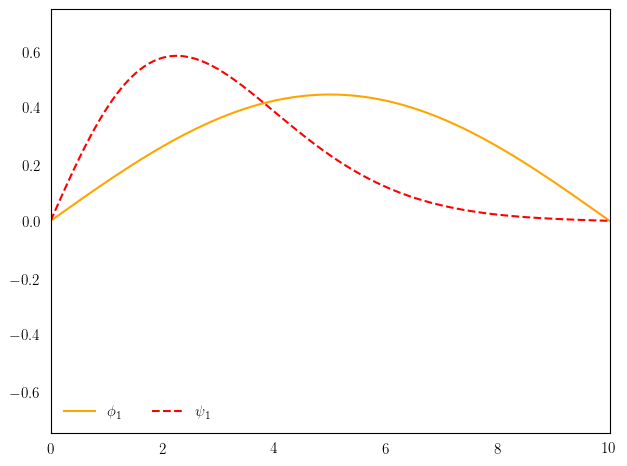

In [8]:
import matplotlib.ticker as plticker
x = np.linspace(0, a, 1000)

n = 1
fig, ax = plt.subplots()

ax.set_xlim(0,a)
ax.set_ylim((-0.75,0.75))

y = psi(n,x)
z = phi(n,x)
ax.plot(x,z, color='orange',label='$\phi_{%i}$' %(n))
ax.plot(x,y, '--r',label='$\psi_{%i}$' %(n))
ax.legend(loc = 'lower left', fancybox=True, framealpha=0.0,ncol=2)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.tight_layout()



# Exercise 1
As a quick exercise, you are invited to play around with the above plots a bit. Change any parameters you wish to. In particular, what happens if you keep decreasing the tilt of the well (without setting it to 0)? What happens if you make it incredibly large? What if we change the size of the well? Are different eigenstates affected differently? Try to think about what you think should happen and whether your guess matches with reality.

# Plotting probability densities
Notice that since the symmetry of our potential is changed, so is the symmetry of our wavefunctions. Previously, the wavefunctions were either symmetric (odd numbered wavefunctions) or anti symmetric (even numbered wavefunctions). We can also see this in the probability densities as well, which are plotted below.

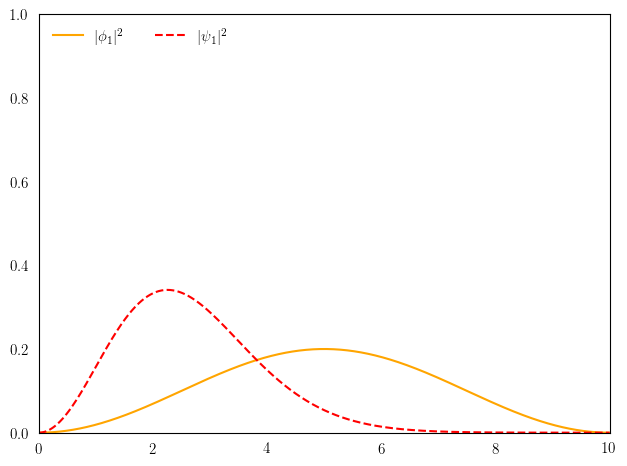

In [9]:
x = np.linspace(0, a, 1000)

n = 1
fig, ax = plt.subplots()

ax.set_xlim(0,a)
ax.set_ylim(0,)

y = psi(n,x)**2
z = phi(n,x)**2
ax.plot(x,z, color='orange',label='$|\phi_{%i}|^2$' %(n))
ax.plot(x,y, '--r',label='$|\psi_{%i}|^2$' %(n))
ax.legend(loc = 'upper left', fancybox=True, framealpha=0.0,ncol=2)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.tight_layout()

# Exercise 2
Again, you are encouraged to take a minute and think about your expectations about the wavefunctions, compared to how they turn out. Adjust the initial conditions and see what changes. 

In particular, think about how the symmetry of the wavefunction is no longer there. For the first eigenstate, clearly, the electron is more likely to be found in the left side of the well now. Can you think of a reason for this? 

Do you think this fact about the position expectation value will hold for all eigenstates of the tilted well? You may be surprised. What happens to the wavefunctions and probabilities as $n$ gets very large?


# Position expectations and standard deviations
As is well known, the position expectation value of the infinite potential well is exactly $\frac{a}{2}$ for all eigenstates, due to the symmetry of the well. Here we will explore how the position expectation and standard deviation (or uncertainty in the position) change with the addition of the tilted well. To calculate these, we use the SciPy function $quad$ to numerically integrate and extract the expectation values of position for the tilted well.

In [10]:
def positionITW(x,n):
    return psi(n,x)*x*psi(n,x)

def positionExpectationITW(n):
    res, err = quad(positionITW,0,a, args=(n,),limit=1000)
    if (abs(res)>=err):
        return res
    else:
        return 0
    
def positionExpectationIPW(n):
    return a/2

    
print("The position expectation of the first state is", positionExpectationITW(1))
print("The position expectation of the third state is", positionExpectationITW(3))

The position expectation of the first state is 2.664853687443604
The position expectation of the third state is 5.470509417202324


Surprisingly, a particle in the third eigenstate is more likely to be found in the right half of the potential well. Why do you think this is?

Let's take a look at the overall trend.

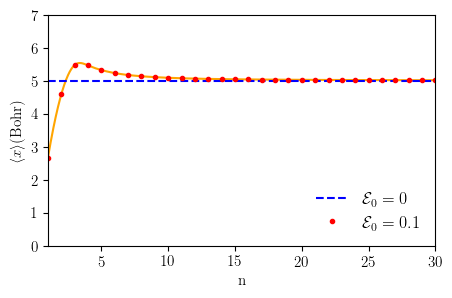

In [11]:
from scipy.interpolate import make_interp_spline, BSpline

j = 30 #the number of states for which we plot the graph

x = np.linspace(1,j,j)

fig = plt.figure(figsize=(5,3), dpi= 100)
ax = fig.add_subplot(1, 1, 1)


expectationsITW = np.zeros(len(x))
expectationsIPW = np.zeros(len(x))


for i in range (1, j+1):
    expectationsITW[i-1] = (positionExpectationITW(i))

for i in range (1, j+1):
    expectationsIPW[i-1] = (positionExpectationIPW(i))

xnew = np.linspace(1,j,1000)
spl = make_interp_spline(x,expectationsITW,k=3) #we create a smooth spline to make the trend clearer
position_smooth = spl(xnew)
ax.plot(xnew,position_smooth,color="orange")

ax.plot(x, expectationsIPW,'--',color='blue', label="$\mathcal{E}_0 = 0$")
ax.plot(x, expectationsITW,'.r',label="$\mathcal{E}_0 = %g$"%e_not)

ax.set_xlabel('n')
ax.set_ylabel(r'$\langle x \rangle$(Bohr)')
ax.set_xlim(1,j)
ax.set_ylim(0,7)


ax.legend(loc = 'lower right', fontsize=12, fancybox=True, framealpha=0.0)

# Optical Transition Spectrum
An important part of the behaviour of any quantum system is how it responds to external perturbations. We can study the probability that the system transitions from one state into another, given any specific perturbation. An important subset of this is optical transitions, which are induced by propagating electromagnetic waves. To find the optical spectrum of the system we consider a linearly polarized electric field, that varies sinusoidally in time. We consider this as an additional potential $V(x, t) = F_0 x cos(\omega t)$ in our system.

The optical spectrum contains information about electronic transitions between energy levels of quantum system either by emission or absorption of electromagnetic radiation. The quantum theory of light-matter interactions dictates the critical rules and strengths with which optical transitions occur. The average power of light emitted is proportional to
$$
\bar{P} = \frac{|M_{mn}|^2 \omega_{mn}^4}{3\pi \epsilon_0 c^3},
$$
where $M_{mn}$ is the transition dipole matrix element. We add a Lorentzian broadening function to more realistically model the line shape.

In [12]:
#Calculating Matrix Elements

f_not = 1 


#for the IPW we can find these matrix elements analytically in a very similar manner as previously
def DipoleCouplingStrengthIPW(n, m):
    if (m == n):
        return 0
    elif ((m+n)%2 == 0):
        return 0
    else:
        return -f_not*(8*a/(np.pi**2))*(m*n/(m**2-n**2)**2)

In [13]:
#For the ITW, we need to integrate numerically
def V(x): 
    return f_not*(x-a/2)

def Helper(x,m,n):
    return psi(m,x)*V(x)*psi(n,x)

def DipoleCouplingStrengthITW(m,n):
    if (m == n):
        return 0
    else:
        res, err = quad(Helper, 0, a, args=(m,n,), limit=1000)
        if (abs(res)>=err):
            return res
        else:
            return 0

In [14]:
length = 3 #Set how many levels we consider transitions between


#Here we just populate some matrices with the dipole matrix elements

DipoleStrengthMatrixIPW = np.zeros((length,length))
for i in range(1,length+1):
    for j in range (1,length+1):
        DipoleStrengthMatrixIPW[i-1,j-1] = DipoleCouplingStrengthIPW(i,j)

DipoleStrengthMatrixITW = np.zeros((length,length))
for i in range(1,length+1):
    for j in range (1,length+1):
        DipoleStrengthMatrixITW[i-1,j-1] = DipoleCouplingStrengthITW(i,j)

#We only care about the absolute values
DipoleCouplingStrengthIPW = np.absolute(DipoleStrengthMatrixIPW)
DipoleCouplingStrengthITW = np.absolute(DipoleStrengthMatrixITW)

#We convert to Debye units which are convenient for coupling strengths
DipoleStrengthMatrixIPWDebye = (DipoleCouplingStrengthIPW)*2.52
DipoleStrengthMatrixITWDebye = (DipoleCouplingStrengthITW)*2.52

In [15]:
matprint(DipoleStrengthMatrixIPWDebye)

      0  4.53919        0  
4.53919        0  4.90232  
      0  4.90232        0  


In [16]:
matprint(DipoleStrengthMatrixITWDebye)

       0  2.82577  0.864381  
 2.82577        0   4.17341  
0.864381  4.17341         0  


Notice that there are some transitions that were not "allowed" in the infinite potential well are now allowed in the tilted well.

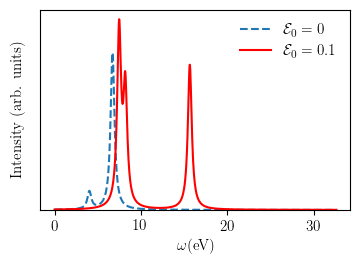

In [17]:
#Here we plot the optical spectra as described previously, using the transition dipole matrix elements found previously

c = 1 #since we are using atomic units we set c = 1
epsilon_not = 1 #since we are using atomic units we set epsilon_not = 1


IPWSpectrumValues  = np.zeros(shape=(length**2,2))
counter = 0
for i in range(1, length+1):
    for j in range(1, length+1):
        if i>j:
            omega = abs(OriginalEnergies[i-1] - OriginalEnergies[j-1])   
            I = ((DipoleStrengthMatrixIPWDebye[i-1,j-1]**2)*(omega**4))/(3*(np.pi)*epsilon_not*(c**3))
            IPWSpectrumValues[counter:counter+1] = [omega, I]
            counter += 1    
IPWSpectrumValues = IPWSpectrumValues[0:counter]

ITWSpectrumValues  = np.zeros(shape=(length**2,2))
counter2 = 0
for i in range(1, length+1):
    for j in range(1, length+1):
        if i>j:
            omega = abs(EnergiesH[i-1] - EnergiesH[j-1])   
            I = ((DipoleStrengthMatrixITWDebye[i-1,j-1]**2)*(omega**4))/(3*(np.pi)*epsilon_not*(c**3))
            ITWSpectrumValues[counter2:counter2+1] = [omega, I]
            counter2 += 1 
ITWSpectrumValues = ITWSpectrumValues[0:counter2]


x = np.linspace(0,1.2, 1000)
IPWSpectrum  = np.zeros(len(x))
ITWSpectrum  = np.zeros(len(x))



for k in range(len(IPWSpectrumValues)):
    IPWSpectrum += cauchy.pdf(x, IPWSpectrumValues[k,0],0.01)*IPWSpectrumValues[k,1]
    
for k in range(len(ITWSpectrumValues)):
    ITWSpectrum += cauchy.pdf(x, ITWSpectrumValues[k,0],0.01)*ITWSpectrumValues[k,1]


xev = 27.2114 * x

fig = plt.figure(figsize=(4,2.6), dpi= 100)
ax = fig.add_subplot(1, 1, 1)

ax.plot(xev, IPWSpectrum,'--', label="$\mathcal{E}_0 = 0$")
ax.plot(xev, ITWSpectrum, 'r', label="$\mathcal{E}_0 = %g$"%e_not)
ax.set_xlabel(r'$$\omega \textnormal{(eV)}$$')
ax.set_ylabel('Intensity (arb. units)')
ax.set_yticklabels([])
ax.set_ylim(0,)
ax.yaxis.set_ticks_position('none')

ax.legend(loc = 'upper right', fontsize=11, fancybox=True, framealpha=0.0)

We see that there are multiple transitions taking place that were previously forbidden. We can **break** the symmetry of the well by introducing the tilt, allowing for more transitions. This can have important consequences.

# Exercise
See what happens when you change the number of states we are considering. What if we alter the tilt or strength of the control field?

# We're done!
We hope you have learned from this. If you are interested, further reading can be found [here](). Suggestions, remarks and questions are welcome!
